In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [10]:
import sqlite3
import json

In [11]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


## Read in data

read in station name

In [12]:
with open('buoy_station_name.json','r') as outfile:
    stndata=json.load(outfile)

data=[]
for ids in stndata:
    info = stndata[ids]
    data.append([ids,info['STN'],info['LAT'],info['LON'],info['LOCATE'],info['OWNER']])
    
# set up column names
columns = ['ST', 'STN','LAT','LON','LOCATE','OWNER']

# list to DataFrame 
stdf = pd.DataFrame(data=data,columns=columns)
stdf

,ST,STN,LAT,LON,LOCATE,OWNER
0,4N11,將軍,null,null,臺南將軍安檢所樓頂,氣象局
1,46694A,龍洞浮標,25.097778,121.9225,東北角龍洞遊艇港外海約0.25公里，該處水深約27公尺。,中央氣象局
2,46699A,花蓮浮標,24.031944,121.631389,花蓮七星潭外海約1公里，該處水深約30公尺。,中央氣象局
3,46708A,龜山島浮標,24.846667,121.926111,宜蘭龜山島龜尾端西方1公里，該處水深約25公尺。,交通部觀光局
4,46714D,小琉球浮標,22.313611,120.362778,小琉球海子口西南方外海約1.2公里，該處水深約99公尺。,中央氣象局
...,...,...,...,...,...,...
97,1306,臺北港,25.156667,121.371667,臺北港第3港埠,氣象局
98,1821,福隆,25.021667,121.95,福隆漁港碼頭,氣象局
99,1315,彭佳嶼,25.625278,122.075556,彭佳嶼海水淡化廠附近,氣象局
100,1551,和平港,24.297778,121.753889,花蓮和平港防波堤,和平工業港公司


## read in data from local sqlite database
read in data 

In [13]:
def read_sql(filename):
    conn = sqlite3.connect(filename, timeout=10)
    df = pd.read_sql("SELECT * FROM status",con=conn)
    conn.close()
    return df

filename = 'buoy_data.sqlite.db'
df = read_sql(filename)

In [14]:
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

df['H']        = df['H'].astype('float')/100.
df['T']        = df['T'].astype('float')
df['Tmean']    = df['Tmean'].astype('float')

df['Temp']     = df['Temp'].astype('float')
df['Zt']       = df['Zt'].astype('float')

df['Vm']       = df['Vm'].astype('float')
df['Dm']       = df['Dm'].astype('float')
df['Vg']       = df['Vg'].astype('float')
df['Vms']      = df['Vms'].astype('float')
df['Vgs']      = df['Vgs'].astype('float')
df['Zv']       = df['Zv'].astype('float')

df['P']        = df['P'].astype('float')

df['Vmsat']    = df['Vmsat'].astype('float')

### add STN station name variable 

In [17]:
def label_stname (row):
    if row['ST'] in stndata:
        return stndata[row['ST']]['STN']
    
df['STN'] = df.apply (lambda row: label_stname(row), axis=1)

## clean data

In [18]:
from datetime import datetime
dataset = df[['STN','ST','DATETIME','H','Temp','P','Vm','Vmsat']]

df_index = (dataset['DATETIME']>datetime(2015,1,1,0)) & (dataset['DATETIME']<datetime(2020,1,1,0))
dataset = dataset[df_index]

#stnlist=['新竹浮標','龜山島浮標','臺東外洋浮標','龍洞浮標','小琉球浮標','花蓮浮標','東沙島浮標','馬祖浮標']

stnlist=['東沙島浮標']
dataset = dataset[dataset['STN'].isin(stnlist)]

dataset = dataset.dropna()

In [19]:
dataset.isna().sum()

STN         0
ST          0
DATETIME    0
H           0
Temp        0
P           0
Vm          0
Vmsat       0
dtype: int64

Drop those rows to keep this initial tutorial simple.

In [20]:
dataset = dataset.dropna()
dataset.tail()

,STN,ST,DATETIME,H,Temp,P,Vm,Vmsat
870948,東沙島浮標,C6V27,2018-12-30 18:00:00,5.08,23.2,1021.8,8.6,15.245345
870954,東沙島浮標,C6V27,2018-12-31 00:00:00,4.14,23.1,1022.4,10.1,13.653247
870960,東沙島浮標,C6V27,2018-12-31 06:00:00,3.43,23.0,1022.2,11.8,13.653247
870966,東沙島浮標,C6V27,2018-12-31 12:00:00,3.35,23.1,1021.9,10.0,13.653247
870972,東沙島浮標,C6V27,2018-12-31 18:00:00,3.22,23.0,1022.0,9.5,13.653247


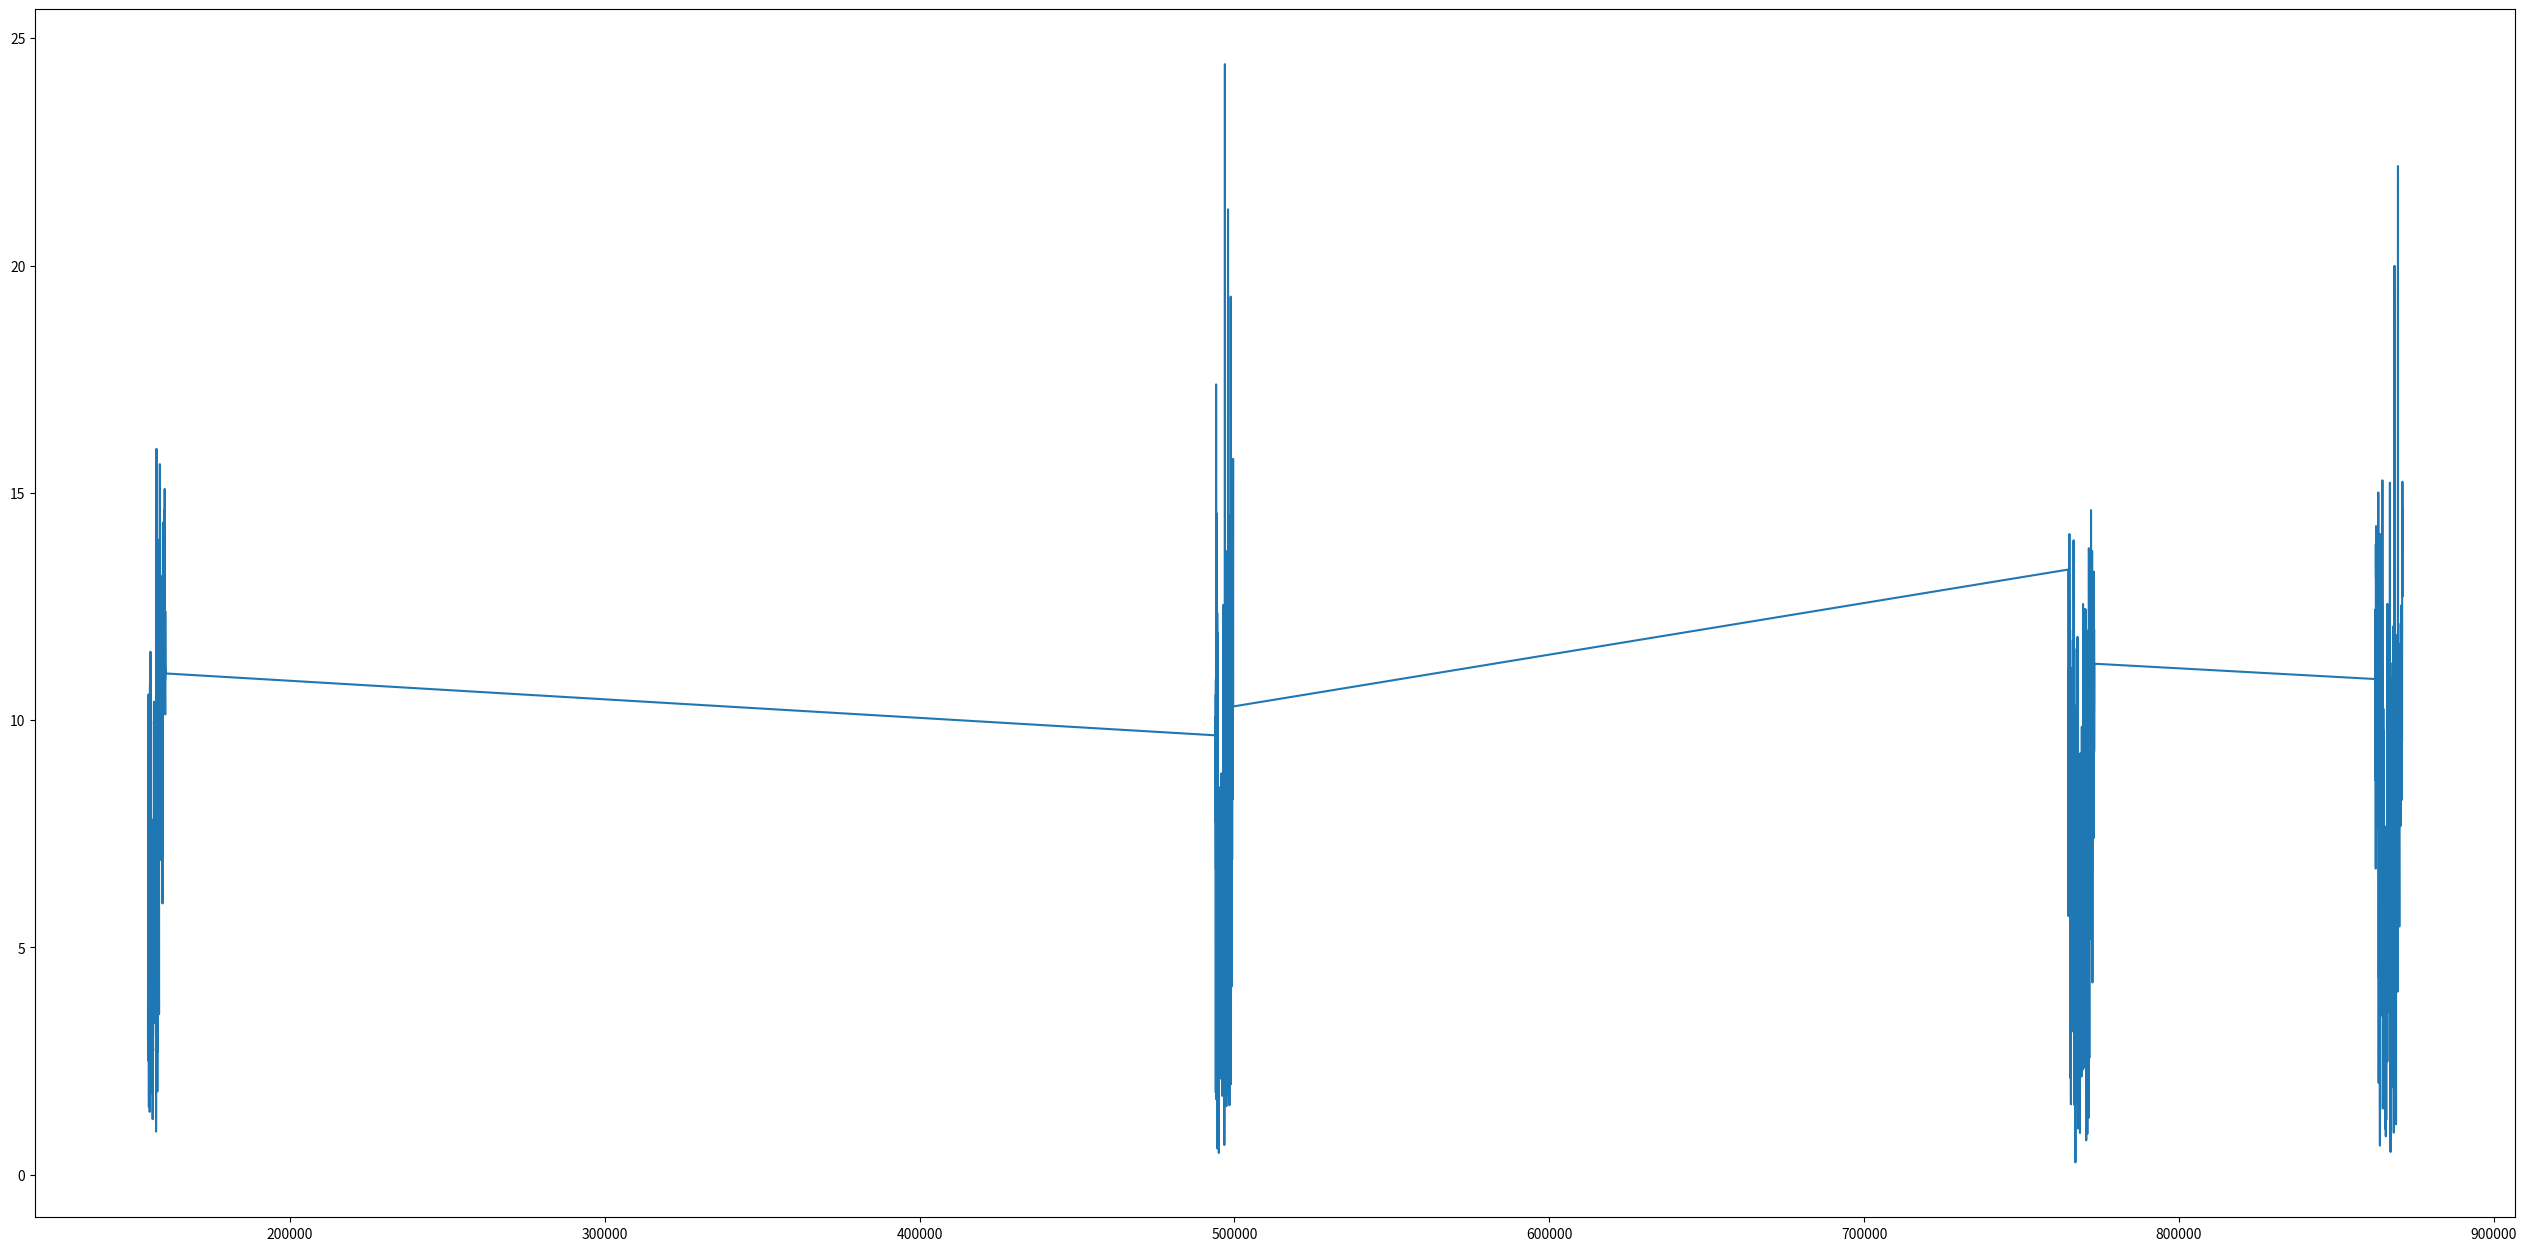

In [21]:
plt.figure(figsize=(32,16),dpi=100)
plt.plot(dataset['Vmsat'])

### Split the data into train and test

Now split the dataset into a training set and a test set.

Use the test set in the final evaluation of your models.

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [ ]:
sns.pairplot(train_dataset[['H', 'P', 'Temp', 'Vm','Vmsat']], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [ ]:
train_dataset.describe().transpose()

### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('H')
test_labels = test_features.pop('H')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable.

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [ ]:
normalizer = preprocessing.Normalization(axis=-1)

Then `.adapt()` it to the data:

In [ ]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [ ]:
print(normalizer.mean.numpy())

When the layer is called it returns the input data, with each feature independently normalized:

In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

## Linear regression

Before building a DNN model, start with a linear regression.

### One Variable

Start with a single-variable linear regression, to predict `H` from `Vmsat`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input `Vmsat`.
* Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the horsepower `Normalization` layer:

In [ ]:
Vmsat = np.array(train_features['Vmsat'])

Vmsat_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
Vmsat_normalizer.adapt(Vmsat)

Build the sequential model:

In [ ]:
Vmsat_model = tf.keras.Sequential([
    Vmsat_normalizer,
    layers.Dense(units=1)
])

Vmsat_model.summary()

This model will predict `H` from `Vmsat`.

Run the untrained model on the first 10 Vmsat values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [ ]:
Vmsat_model.predict(Vmsat[:10])

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [ ]:
Vmsat_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use `Model.fit()` to execute the training:

In [ ]:
%%time
history = Vmsat_model.fit(
    train_features['Vmsat'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Visualize the model's training progress using the stats stored in the `history` object.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [H]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

Collect the results on the test set, for later:

In [ ]:
test_results = {}

test_results['Vmsat_model'] = Vmsat_model.evaluate(
    test_features['Vmsat'],
    test_labels, verbose=0)

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [ ]:
x = tf.linspace(0.0, 20, 251)
y = Vmsat_model.predict(x)

In [ ]:
def plot_Vmsat(x, y):
  plt.scatter(train_features['Vmsat'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Vmsat')
  plt.ylabel('H')
  plt.legend()

In [ ]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vmsat(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [ ]:
linear_model.predict(train_features[:10])

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(4,1)`.

In [ ]:
linear_model.layers[1].kernel

Use the same `compile` and `fit` calls as for the single input `Vmsat` model:

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
plot_loss(history)

In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [ ]:
x = tf.linspace(0.0, 50, 251)
y = linear_model.predict(x)

In [ ]:
plot_Vmsat(x,y)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### One variable

Start with a DNN model for a single input: "Vmsat"

In [ ]:
dnn_Vmsat_model = build_and_compile_model(Vmsat_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [ ]:
dnn_Vmsat_model.summary()

Train the model:

In [ ]:
%%time
history = dnn_Vmsat_model.fit(
    train_features['Vmsat'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [ ]:
plot_loss(history)

In [ ]:
x = tf.linspace(0.0, 20, 251)
y = dnn_Vmsat_model.predict(x)

In [ ]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vmsat(x,y)

In [ ]:
test_results['dnn_Vmsat_model'] = dnn_Vmsat_model.evaluate(
    test_features['Vmsat'], test_labels,
    verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

In [ ]:
x = tf.linspace(0.0, 20, 251)
y1 = dnn_Vmsat_model.predict(x)
y = linear_model.predict(x)
y = Vmsat_model.predict(x)